In [1]:
import os
import requests
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tqdm import tqdm
import gc

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
SEED = 42
RNG = torch.Generator().manual_seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

import sys
sys.path.append('../../')
from utils import *

import pickle
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import PIL

Running on device: CUDA


In [2]:
SAVE = False

In [3]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
with open('./imbalanced_dataset.pkl', 'rb') as file:
    imbalanced_aug_dataset_id = pickle.load(file)

# Extract the X and Y components from the dataset
X = [item[0] for item in imbalanced_aug_dataset_id]
Y = [item[1] for item in imbalanced_aug_dataset_id]
indices = [x for x in range(len(imbalanced_aug_dataset_id))]

# First split: separate out the training set
X_temp, X_train, Y_temp, Y_train, indices_temp, indices_train = train_test_split(X, Y, indices, test_size=0.6, stratify=Y, random_state=42)

# Second split: separate out the validation and test sets from the temporary set
X_val, X_test, Y_val, Y_test, indices_val, indices_test = train_test_split(X_temp, Y_temp, indices_temp, test_size=0.5, stratify=Y_temp, random_state=42)

# Re-create the stratified datasets using the new indices
train_set = list(zip(X_train, Y_train, indices_train))
val_set = list(zip(X_val, Y_val, indices_val))
test_set = list(zip(X_test, Y_test, indices_test))

In [5]:
if SAVE:
    np.save('./train_idx.npy',indices_train)
    np.save('./val_idx.npy',indices_val)
    np.save('./test_idx.npy',indices_test)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        x, y, z = self.data_list[idx]

        # If x is a PIL.Image, convert it to a tensor
        if isinstance(x, PIL.Image.Image):
            x = transforms.ToTensor()(x)

        # Apply additional transformations (like normalization)s
        if self.transform:
            x = self.transform(x)

        return (x, y)  # Explicitly return as tuple

# download and pre-process CIFAR10
train_normalize = transforms.Compose(
    [
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

test_normalize = transforms.Compose(
    [
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_dataset = CustomDataset(train_set, transform=train_normalize)
val_dataset = CustomDataset(val_set, transform=test_normalize)
test_dataset = CustomDataset(test_set, transform=test_normalize)

In [7]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=RNG)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, generator=RNG)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, generator=RNG)

### LOAD

In [8]:
# train_idx = np.load('./train_idx.npy')
# retain_idx = np.load('./retain_idx.npy')
# forget_idx = np.load('./forget_idx.npy')
# val_idx = np.load('./val_idx.npy')
# test_idx = np.load('./test_idx.npy')

# train_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, train_idx)
# forget_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, forget_idx)
# retain_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, retain_idx)
# val_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, val_idx)
# test_set = torch.utils.data.Subset(imbalanced_aug_dataset_id, test_idx)

# train_dataset = CustomDataset(train_set, transform=train_normalize)
# test_dataset = CustomDataset(test_set, transform=test_normalize)
# val_dataset = CustomDataset(val_set, transform=test_normalize)

# batch_size = 16

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)#, generator=RNG)

In [9]:
list_of_targets = []

with torch.no_grad():
    for sample in train_loader:
        # Get logits
        targets = sample[1]
        list_of_targets.append(np.array(targets))
        
train_class_weights = torch.tensor(1/np.bincount(np.concatenate(list_of_targets).ravel())).to(DEVICE, dtype=torch.float32)

if SAVE:
    np.save('./train_class_weights.npy',train_class_weights.cpu().numpy())

In [11]:
# load model with pre-trained weights
net = resnet18(weights=None, num_classes=10)
net.to(DEVICE);

epochs = 30
val_loss = np.inf


current_batch = 0
total_samples = len(train_loader.dataset)
batch_size = train_loader.batch_size
batches_per_epoch  = math.ceil(total_samples / batch_size)
total_batches = epochs * batches_per_epoch
initial_lr = 1e-4
warmup_batches = math.ceil(10*total_batches)


criterion = nn.CrossEntropyLoss(weight=train_class_weights)
optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.90, weight_decay=5e-2)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for ep in range(epochs):

    net.train()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        current_batch += 1

        # Warm-up for the first 'warmup_batches' batches
        # if current_batch <= warmup_batches:
        #     adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # nn.utils.clip_grad_value_(net.parameters(), 10)

        optimizer.step()


    net.eval()  # handle drop-out/batch norm layers

    loss = 0
    with torch.no_grad():
        for x,y in train_loader:
            out = net(x.to(DEVICE))  # only forward pass - NO gradients!!
            loss += criterion(out, y.to(DEVICE))
    # total loss - divide by number of batches
    train_loss = loss / len(train_loader)
    train_losses.append(train_loss)

    loss = 0
    with torch.no_grad():
        for x,y in val_loader:
            out = net(x.to(DEVICE))  # only forward pass - NO gradients!!
            loss += criterion(out, y.to(DEVICE))
    # total loss - divide by number of batches
    val_loss = loss / len(val_loader)
    val_losses.append(val_loss)

    print('--------'*5)
    print(f'Epoch: {ep}')
    print(f'Train loss: {train_loss}')
    print(f'Val loss: {val_loss}')
    
    net.eval()
    train_acc = accuracy(net, train_loader)
    train_accs.append(train_acc)
    val_acc = accuracy(net, val_loader)
    val_accs.append(val_acc)
    print(f"Train set accuracy: {100.0 * train_acc:0.1f}%")
    # print(f"Forget set accuracy: {100.0 * accuracy(net, forget_loader):0.1f}%")
    print(f"Val set accuracy: {100.0 * val_acc:0.1f}%")
    # print(f"Test set accuracy: {100.0 * accuracy(net, test_loader):0.1f}%")

    # if temp_loss < val_loss:
    #     val_loss = temp_loss
    
    scheduler.step(val_loss)

    gc.collect()
    torch.cuda.empty_cache()

----------------------------------------
Epoch: 0
Train loss: 1.5010720491409302
Val loss: 1.560833215713501
Train set accuracy: 56.8%
Val set accuracy: 56.1%
----------------------------------------
Epoch: 1
Train loss: 1.3116940259933472
Val loss: 1.4157854318618774
Train set accuracy: 69.4%
Val set accuracy: 67.1%
----------------------------------------
Epoch: 2
Train loss: 1.2313557863235474
Val loss: 1.3987634181976318
Train set accuracy: 71.3%
Val set accuracy: 68.9%
----------------------------------------
Epoch: 3
Train loss: 1.1009868383407593
Val loss: 1.278664469718933
Train set accuracy: 70.1%
Val set accuracy: 67.4%
----------------------------------------
Epoch: 4
Train loss: 1.0156947374343872
Val loss: 1.2225165367126465
Train set accuracy: 74.7%
Val set accuracy: 70.5%
----------------------------------------
Epoch: 5
Train loss: 0.9781247973442078
Val loss: 1.2327420711517334
Train set accuracy: 74.3%
Val set accuracy: 69.9%
----------------------------------------
E

In [12]:
# if SAVE:
torch.save({
    'net': net.state_dict(),
}, f'./internal_imbalanced_weights_resnet18_cifar10.pth')

In [13]:
def calculate_loss(model, inputs, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        loss = torch.nn.CrossEntropyLoss(reduction="none")(outputs, targets)
    return loss.detach().cpu().numpy()

In [14]:
original_losses = []

for inputs, targets in train_loader:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    batch_losses = calculate_loss(net, inputs, targets)
    original_losses.extend(batch_losses)

In [15]:
val_losses = []

for inputs, targets in val_loader:
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    batch_losses = calculate_loss(net, inputs, targets)
    val_losses.extend(batch_losses)

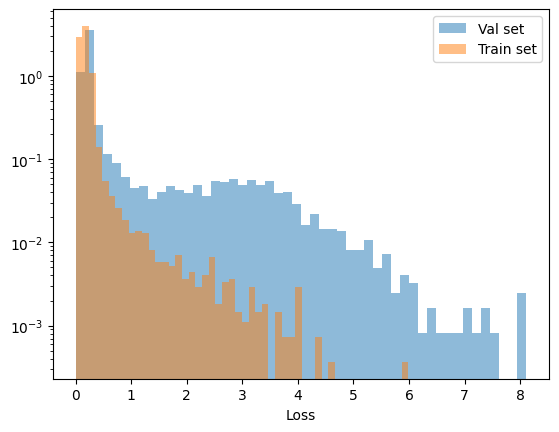

In [16]:
fig = plt.Figure(figsize=(16, 6))


plt.hist(val_losses, density=True, alpha=0.5, bins=50, label="Val set")
plt.hist(original_losses, density=True, alpha=0.5, bins=50, label="Train set")

plt.xlabel("Loss")
plt.yscale("log")
# plt.xlim((0, np.max(val_losses)))
plt.legend()

plt.show()

In [17]:
# # Second split: separate out the validation and test sets from the temporary set
# X_retain, X_forget, Y_retain, Y_forget, indices_retain, indices_forget = train_test_split(X_train, Y_train, indices_train, test_size=0.02, stratify=Y_train, random_state=42)

# if SAVE:
#     np.save('./retain_idx.npy', indices_retain)
#     np.save('./forget_idx.npy', indices_forget)